# SWR

A flexible framework for safe withdrawal rate experiments.

Framework can generalize to
- Any generator of asset returns
- Any asset allocation strategy based on age, returns etc.
- Any utility function to evaluate suitability of strategy (e.g. total spending, certainty equivalent spending)
- Support a survival table 
- Any optimizer to find optimal parameters for a given withdrawal framework and market simulation


In [1]:
from datetime import datetime

import pytest
import numpy as np
import pandas as pd
import pandas_datareader as pdr

from SWRsimulation import SWRsimulation

In [2]:
def datestr():
    return datetime.strftime(datetime.now(), "%Y-%m-%d %H:%M:%S")


In [3]:
# load Damodaran data from pickle (via http://people.stern.nyu.edu/adamodar/New_Home_Page/datafile/histretSP.html )
RETURN_FILE = 'histretSP'
def load_returns():
    return pd.read_pickle('%s.pickle' % RETURN_FILE)

download_df = load_returns()
return_df = download_df.iloc[:, [0, 3, 12]]
return_df.columns=['stocks', 'bonds', 'cpi']

return_df

,stocks,bonds,cpi
Year,,,
1928,0.438112,0.032196,-0.011522
1929,-0.082979,0.030179,0.000000
1930,-0.251236,0.005398,-0.026712
1931,-0.438375,-0.156808,-0.089321
1932,-0.086424,0.235896,-0.103014
...,...,...,...
2016,0.117731,0.103651,0.012616
2017,0.216055,0.097239,0.021301
2018,-0.042269,-0.027626,0.024426


In [4]:
# should adjust CPI to year-ending also but leave it for now
real_return_df = return_df.copy()
# real_return_df.loc[1948:, 'cpi'] = cpi_test['cpi_fred']
# adjust returns for inflation
real_return_df['stocks'] = (1 + real_return_df['stocks']) / (1 + real_return_df['cpi']) - 1
real_return_df['bonds'] = (1 + real_return_df['bonds']) / (1 + real_return_df['cpi']) - 1
real_return_df.drop('cpi', axis=1, inplace=True)
real_return_df.to_pickle('real_return_df.pickle')

real_return_df

,stocks,bonds
Year,,
1928,0.454874,0.044227
1929,-0.082979,0.030179
1930,-0.230686,0.032991
1931,-0.383290,-0.074106
1932,0.018495,0.377832
...,...,...
2016,0.103805,0.089901
2017,0.190692,0.074354
2018,-0.065104,-0.050811


In [5]:
# check values per appendix of Bengen paper https://www.retailinvestor.org/pdf/Bengen1.pdf
# nominal return 10% for stocks, 5% for bonds
# inflation 3%
# fixed spending of 4% of orig port
STOCK_RETURN = (1.1 / 1.03) - 1
BOND_RETURN = (1.05 / 1.03) - 1
VARIABLE = 0.0
FIXED = 4.0
N_RET_YEARS = 30

returns_df = pd.DataFrame(index=range(1928, 2021), 
                          data={'stocks': STOCK_RETURN, 
                                'bonds': BOND_RETURN})

s = SWRsimulation.SWRsimulationCE({
    'simulation': {'returns_df': returns_df,
                   'n_ret_years': N_RET_YEARS,
                  },
    'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED,
                   'variable_pct': VARIABLE},
    'analysis': {
    },
    'evaluation': {}, # no args, default = number of years to exhaustion
})

print(s)

# a single trial starting in 1928
z = s.simulate_trial(next(s.simulation['trials']))

# match figures in appendix
# example uses nominal vals with 3% inflation, we use real vals
assert z.iloc[0]['before_spend'] * 1.03 == pytest.approx(107.5, 0.000001)
assert z.iloc[0]['spend'] * 1.03 == 4.12, "spend does not match Bengen"
assert z.iloc[0]['end_port'] * 1.03 == pytest.approx(103.38, 0.000001), "ending port does not match Bengen"

z

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
1928  0.067961  0.019417
1929  0.067961  0.019417
1930  0.067961  0.019417
1931  0.067961  0.019417
1932  0.067961  0.019417
...        ...       ...
2016  0.067961  0.019417
2017  0.067961  0.019417
2018  0.067961  0.019417
2019  0.067961  0.019417
2020  0.067961  0.019417

[93 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.historical_trials at 0x7ff4789b65d0>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed': 4.0, 'fixed_pct': 4.0, 'variable': 0.0, 'variable_pct': 0.0}


,start_port,port_return,before_spend,spend,end_port,alloc_0,alloc_1
1928,100.000000,0.043689,104.368932,4.0,100.368932,0.5,0.5
1929,100.368932,0.043689,104.753982,4.0,100.753982,0.5,0.5
1930,100.753982,0.043689,105.155855,4.0,101.155855,0.5,0.5
1931,101.155855,0.043689,105.575286,4.0,101.575286,0.5,0.5
1932,101.575286,0.043689,106.013041,4.0,102.013041,0.5,0.5
1933,102.013041,0.043689,106.469922,4.0,102.469922,0.5,0.5
1934,102.469922,0.043689,106.946763,4.0,102.946763,0.5,0.5
1935,102.946763,0.043689,107.444437,4.0,103.444437,0.5,0.5
1936,103.444437,0.043689,107.963854,4.0,103.963854,0.5,0.5
1937,103.963854,0.043689,108.505964,4.0,104.505964,0.5,0.5


Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.historical_trials at 0x7ff4789b6cd0>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed': 4.0, 'fixed_pct': 4.0, 'variable': 0.0, 'variable_pct': 0.0}
mean annual spending over all cohorts 4.00
0.00% of portfolios exhausted by final year


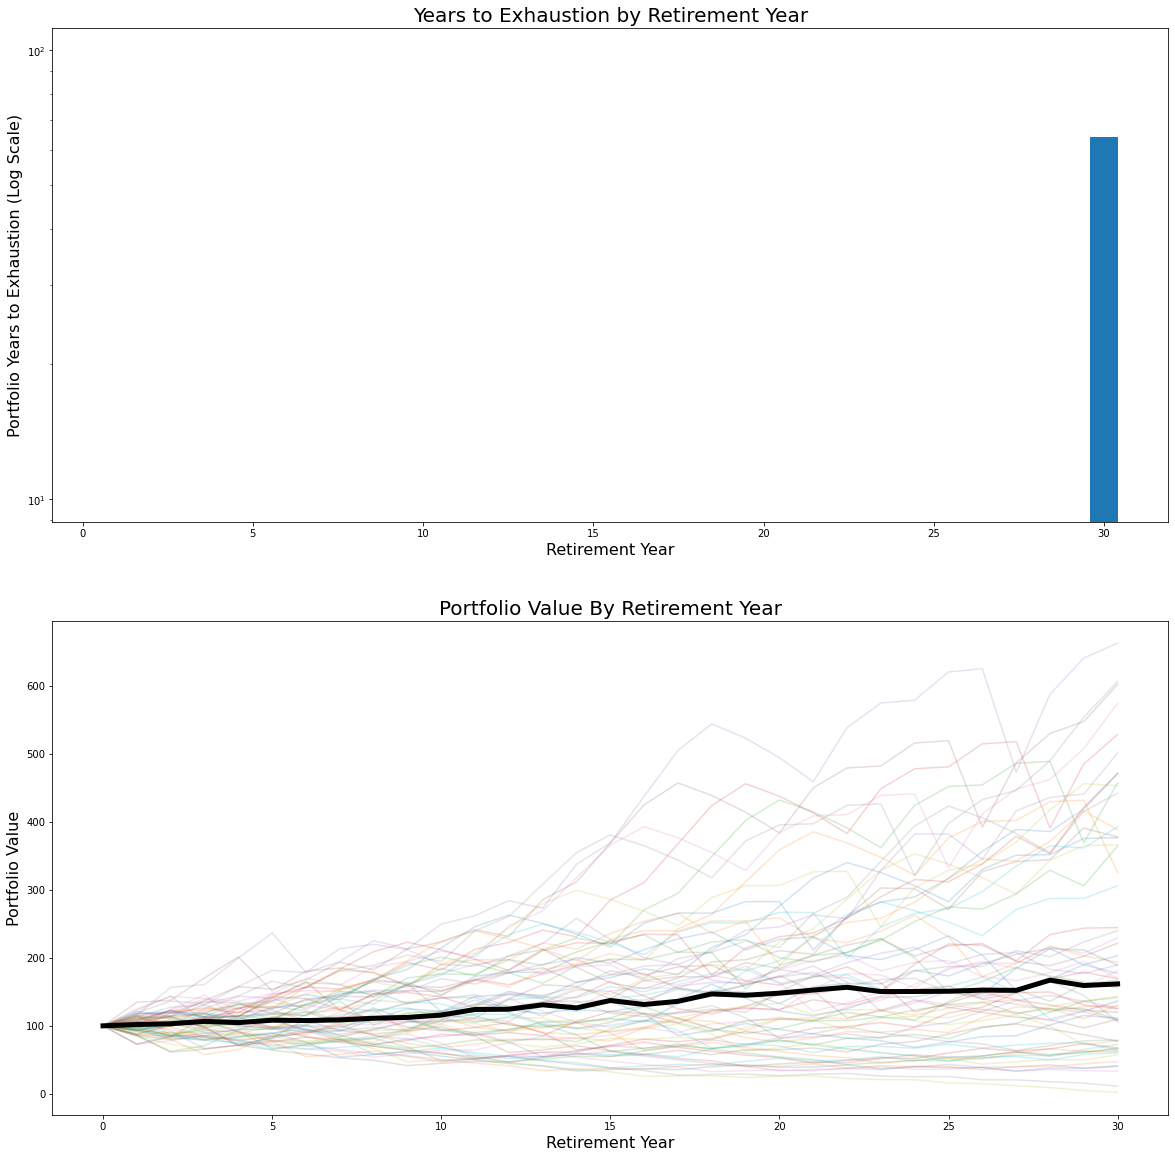

In [6]:
# Bengen 4% rule
VARIABLE = 0.0
FIXED = 4.0
N_RET_YEARS = 30

s = SWRsimulation.SWRsimulationCE({
    'simulation': {'returns_df': real_return_df,
                   'n_ret_years': N_RET_YEARS,
                  },
    'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED,
                   'variable_pct': VARIABLE},
    'evaluation': {'gamma': 1}, 
    'analysis': {'histogram': True,
                 'chart_1' : {'title': 'Years to Exhaustion by Retirement Year'},
                 'chart_2' : {'title': 'Portfolio Value By Retirement Year'},
                }    # chart options etc.
})

print(s)

s.simulate() # returns array of trials (by default all historical retirement periods)
s.analyze()  # chart of latest simulation

In [7]:
# instead of historical, do 1000 montecarlo trials
# for each year of retirement, draw a random year from history to generate performance

Simulation:
{'montecarlo': 1000,
 'montecarlo_replacement': True,
 'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.montecarlo_trials at 0x7ff46a123a50>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed': 4.0, 'fixed_pct': 4.0, 'variable': 0.0, 'variable_pct': 0.0}


/Users/drucev/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/drucev/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/drucev/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/drucev/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/drucev/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/drucev/opt/anaconda3/lib/python3.7/site-packages/pandas/core/se

mean annual spending over all cohorts 3.96
4.30% of portfolios exhausted by final year


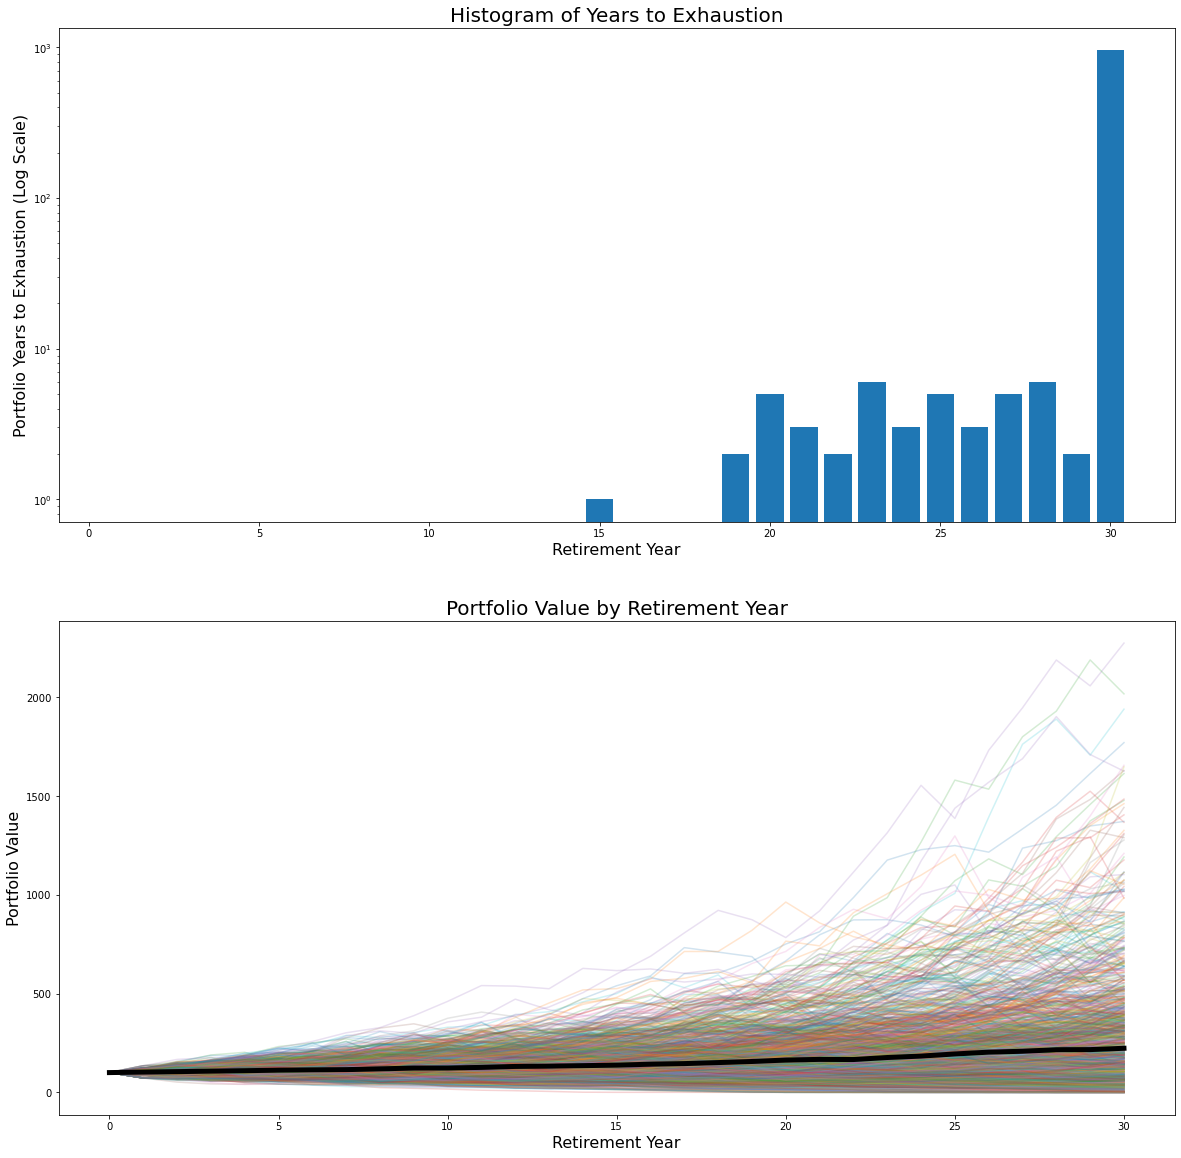

In [8]:
VARIABLE = 0.0
FIXED = 4.0
N_RET_YEARS = 30
NTRIALS = 1000

s = SWRsimulation.SWRsimulationCE({
    'simulation': {'returns_df': real_return_df,
                   'montecarlo': NTRIALS,
                   'montecarlo_replacement': True,
                   'n_ret_years': N_RET_YEARS,
                  },
    'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED,
                   'variable_pct': VARIABLE},
    'evaluation': {'gamma': 1}, # no args, default = number of years to exhaustion
    'analysis': {'histogram': True}    
})

print(s)

# don't keep 1000 historical arrays, just return a single eval for each trial
# eval is the years to exhaustion (30 if never exhausted)
s.simulate()
s.analyze()  # chart of latest simulation

In [9]:
# bengen rule
# suppose portfolio goes up, by induction if 4% is good for 30 years you can safely increase
# if portfolio goes down it's safer to do 4% of new value. if you spend 4% of value instead of fixed you could never go broke since you adjust on the way down
# so 4% seems like a pretty good number in the sense that in the long run you do OK

# I was curious does 4% hold up under monte carlo?

# so 4% historically has been an OK rule


In [10]:
# have github CI run tests automatically

# .analyze() ... run the 2 plots
# analyze_plotly, analyze
# use montecarlo to find a bad example with 4%
# use a fixture to test the eval code, clean up tests

# function to return ce value based on strategy
# ce value of a stream
# ce value of many ce streams
# run bayesian optimizaton, optuna etc.
# ce value of a set of streams over a mortality curve
# try convex optimization
# go through the scikit optimizers and see if there are other global optimizers that might work eg simulated annealing
# accept an arbitrary schedule, utility function, optimizer


# certainty_equivalent_mortality(k_list, mortality_table)
# calculate probability of being alive in years 1...k
# so now you have k lists with associated probabilities
#    certainty_adjust cash flow streams
#    not just full cash flow but range(nyears) cash flows 
#    then certainty adjust over the probability distribution of each sequence of cash flows
    

Simulation:
{'montecarlo': 1000,
 'montecarlo_replacement': True,
 'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.montecarlo_trials at 0x7ff45139a0d0>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed': 4.0, 'fixed_pct': 4.0, 'variable': 0.0, 'variable_pct': 0.0}


/Users/drucev/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/drucev/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/drucev/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/drucev/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/drucev/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/drucev/opt/anaconda3/lib/python3.7/site-packages/pandas/core/se

/Users/drucev/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/drucev/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/drucev/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/drucev/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/drucev/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/drucev/opt/anaconda3/lib/python3.7/site-packages/pandas/core/se

mean annual spending over all cohorts 3.95
5.70% of portfolios exhausted by final year


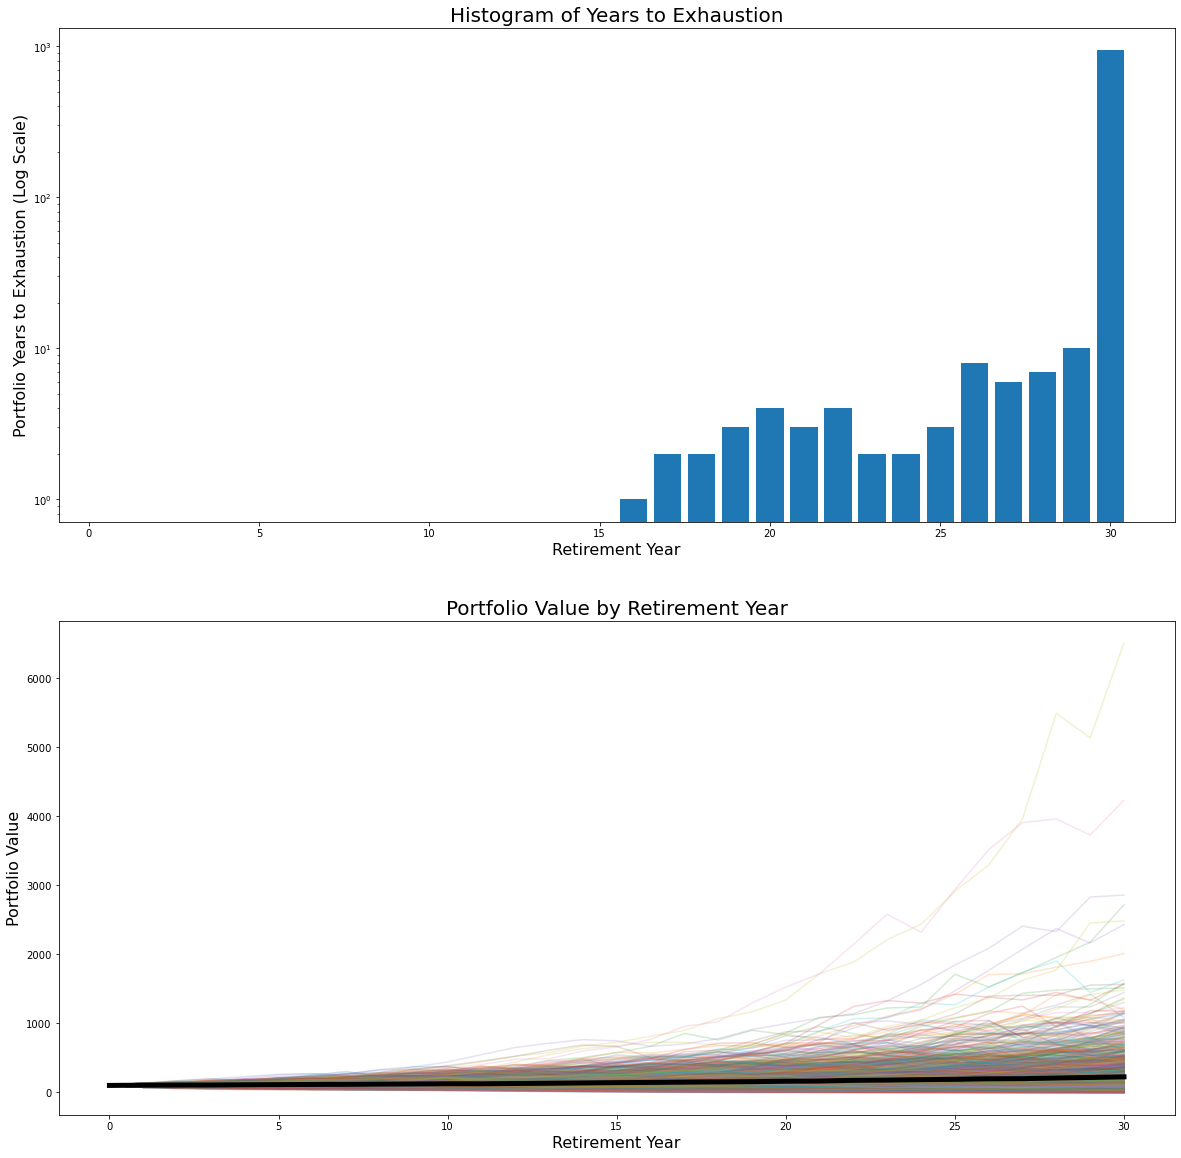

In [11]:
VARIABLE = 0.0
FIXED = 4.0
N_RET_YEARS = 30
NTRIALS = 1000

s = SWRsimulation.SWRsimulationCE({
    'simulation': {'returns_df': real_return_df,
                   'montecarlo': NTRIALS,
                   'montecarlo_replacement': True,
                   'n_ret_years': N_RET_YEARS,
                  },
    'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED,
                   'variable_pct': VARIABLE},
    'evaluation': {'gamma': 1}, # no args, default = number of years to exhaustion
    'analysis': {'histogram': True}    
})

print(s)

s.simulate()
s.analyze()  # chart of latest simulation

In [12]:
FIXED_SPEND = 2
VARIABLE_SPEND = 2
ALLOC_STOCKS = 0.6
ALLOC_BONDS = 0.4
N_RET_YEARS = 30

from functools import partial

def ce_experiment(gamma, fixed_spend, variable_spend, alloc_stocks, n_ret_years):

    alloc_bonds = 1.0 - alloc_stocks

    s = SWRsimulation.SWRsimulation({
        'simulation': {'returns_df': real_return_df,
                       'n_ret_years': n_ret_years,
                      },
        'allocation': {'asset_weights': np.array([alloc_stocks, alloc_bonds])}, 
        'withdrawal': {'fixed_pct': fixed_spend,
                       'variable_pct': variable_spend},
        'evaluation': {},
        'analysis': {}    
    })
    s.simulate()
    return -SWRsimulation.crra_ce(np.array([z['ce_spend'] for z in s.latest_simulation]), gamma)

# freeze gamma=1 using partial
ce_experiment_1 = partial(ce_experiment, 1)
ce_experiment_1(FIXED_SPEND, VARIABLE_SPEND, ALLOC_STOCKS, N_RET_YEARS)




/Users/drucev/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/drucev/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [13]:
# TODO: analyze should compute ce spend over history
# write a function to take 4 parameters, fixed variable stocks bonds and return CE over history
# run optimizer on function



In [14]:
import math
gamma=4
crra_utility = lambda x: (x ** (1 - gamma) - 1) / (1 - gamma)
print(crra_utility (1000000000))
winbet = 110
losebet = 100
w = 1000

win_utils = crra_utility(w + winbet) - crra_utility(w)
loss_utils = crra_utility(w) - crra_utility(w - losebet)
print ('win', win_utils)
print ('loss', loss_utils)
print('edge', win_utils-loss_utils)


0.3333333333333333
win 8.960288067072497e-11
loss 1.2391404569100928e-10
edge -3.4311165020284307e-11


In [15]:
winbet = 2000
losebet = 1000
w = 4000

win_utils = crra_utility(w + winbet) - crra_utility(w)
loss_utils = crra_utility(w) - crra_utility(w - losebet)
print ('win', win_utils)
print ('loss', loss_utils)
print('edge', win_utils-loss_utils)


win 3.665068248892567e-12
loss 7.137401780710206e-12
edge -3.4723335318176396e-12


In [16]:
def general_ce(cashflows, gamma):
    cashflows = np.longdouble(cashflows)
    if gamma == 1:
        u = np.mean(np.log(cashflows))
        ce = np.exp(u)
    else:
        u = np.mean((cashflows ** (1 - gamma) - 1) / (1 - gamma))
        ce = (1 + u * (1 - gamma)) ** (1 / (1 - gamma))
    ce = np.float(ce)
    return ce * len(cashflows)

In [17]:
print (datetime.now())

2021-02-10 12:24:21.617073
